# Lane Detection

# Contributers
1. Le Thanh Tung - 17021352
2. Nguyen Tuan Quoc - 17021326
3. Tran Thu Phuong - 17021321

This notebook is highly inspired by this [project by Udacity](https://github.com/udacity/CarND-LaneLines-P1)

Before start, let's define the problem. We want to detect the lane's lines through a raw image taken from cars' camera. Example input and output are:
*Input*
![Input](input.png)
*Output*
![Output](output.png)


Data taken from [Kitti dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php)

**Procedure**
1. Covert color image to grayscale
2. Smooth image to suppress noise and spurious gradients in preparation of Canny edge detection
3. Canny edge detection
4. Define region of interest (ROI)
5. Use Hough transform to detect lines within ROI
6. Overlay detected lines on image
7. Improve lines in overlay image

Each step will be implemented below

Prepare data and import essential libs

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
PATH = "data_road/lane_img"
img_folder = [os.path.join(PATH, img) for img in os.listdir(PATH) if '.png' in img]
img_folder[:10]

['data_road/lane_img/um_000002.png',
 'data_road/lane_img/um_000003.png',
 'data_road/lane_img/um_000013.png',
 'data_road/lane_img/um_000014.png',
 'data_road/lane_img/um_000015.png',
 'data_road/lane_img/um_000016.png',
 'data_road/lane_img/um_000017.png',
 'data_road/lane_img/um_000018.png',
 'data_road/lane_img/um_000019.png',
 'data_road/lane_img/um_000020.png']

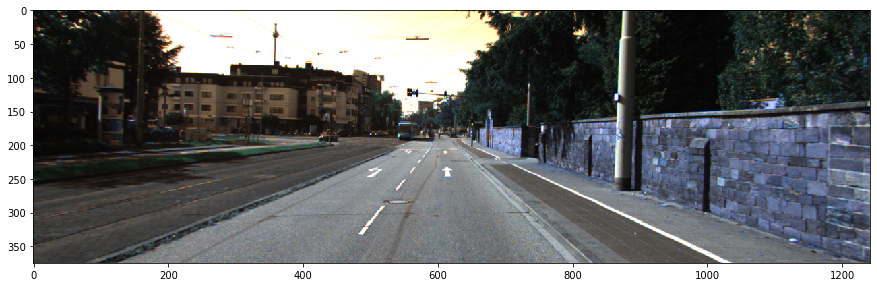

In [5]:
#show an image
img = cv2.imread(img_folder[0])
plt.figure(figsize=(15,15))
plt.imshow(img)

## Convert color image to gray scale

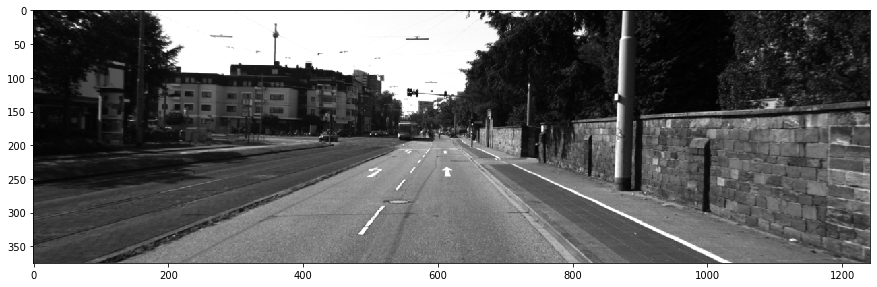

In [6]:
# conver to gray
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(15,15))
plt.imshow(img_gray, cmap='gray')


## Smooth image to suppress noise and spurious gradients in preparation of Canny edge detection
In this situation, we apply Gaussian blur to reduce noise

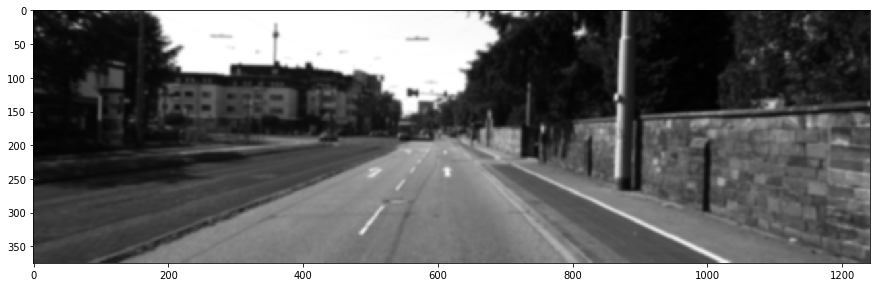

In [7]:
#Apply Gaussian blur
kernel_size=11
blur = cv2.GaussianBlur(img_gray, (kernel_size, kernel_size), 0)
plt.figure(figsize=(15,15))
plt.imshow(blur, cmap='gray')

## Canny edge detection
The Canny edge detection algorithm is composed of 5 steps:
1. Noise reduction;
2. Gradient calculation;
3. Non-maximum suppression;
4. Double threshold;
5. Edge Tracking by Hysteresis.

- High threshold is used to identify the strong pixels (intensity higher than the high threshold)
- Low threshold is used to identify the non-relevant pixels (intensity lower than the low threshold)

Visit this [blog](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123) to know more about the details

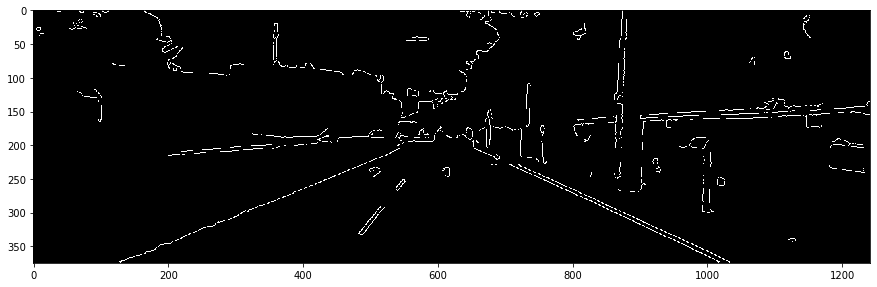

In [90]:
#canny edge detection
low_threshold = 50
high_threshold = 150
canny = cv2.Canny(blur, low_threshold, high_threshold)
plt.figure(figsize=(15,15))
plt.imshow(canny, cmap='gray')

## Then, we grab all above to a function for reproduceable purpose 

Exactly the same as above


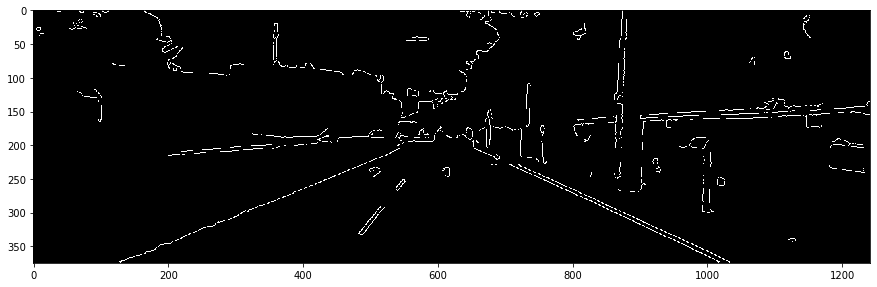

In [91]:
#grab all above function as get_canny
def get_canny(img):
    """
    Input: take a raw image
    Output: detect edges of img using canny
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(img_gray, (11, 11), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

canny = get_canny(img)
plt.figure(figsize=(15,15))
print("Exactly the same as above")
plt.imshow(canny, cmap='gray')

## Define region of interest (ROI)
1. Define a triangle as region of interes. After explore the dataset, we conclude most ROIs are from coordinate (100,height), (1100, height), (600,150) where height is the height of image
2. Create a mask filled with the triangle 
3. Apply bitwise operator to get ROI as below

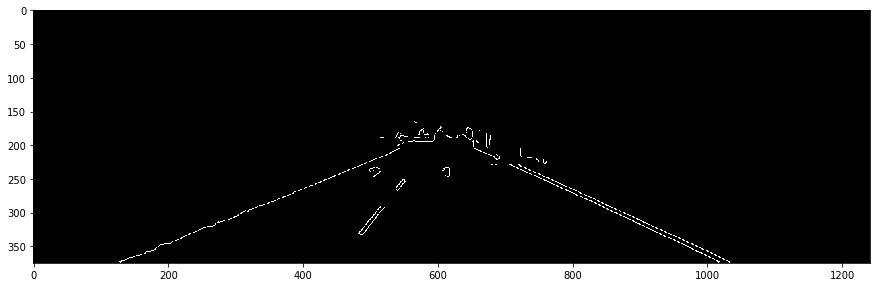

In [92]:
def region_of_interest(img):
    """
    Input: get a edge img, vertices as the limit of ROI
    Output: A mask of img which only contains ROI
    """
    height = img.shape[0]
    polygon = np.array([[(100,height), (1100, height), (600,150)]])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, polygon, 255)
    mask_img = cv2.bitwise_and(img, mask)
    return mask_img

mask = region_of_interest(canny)
plt.figure(figsize=(15,15))
plt.imshow(mask, cmap='gray')

## Use Hough transform to detect lines within ROI
## Overlay detected lines on image

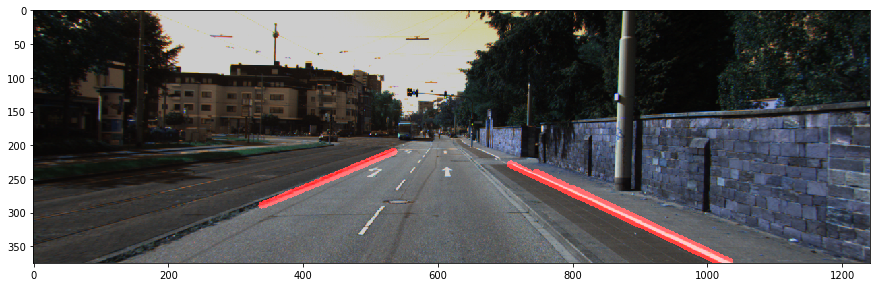

In [93]:
def display_lines(img, lines):
    line_img = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_img, (x1, y1),(x2, y2), (255,0,0), 10)
    return line_img
lines = cv2.HoughLinesP(mask, 2, np.pi/180,100, np.array([]), minLineLength=40, maxLineGap=5)

line_img = display_lines(img, lines)
    combine_line_img = cv2.addWeighted(img, 0.8, line_img, 1, 1)
plt.figure(figsize=(15,15))
plt.imshow(combine_line_img)

## Improve lines in overlay image

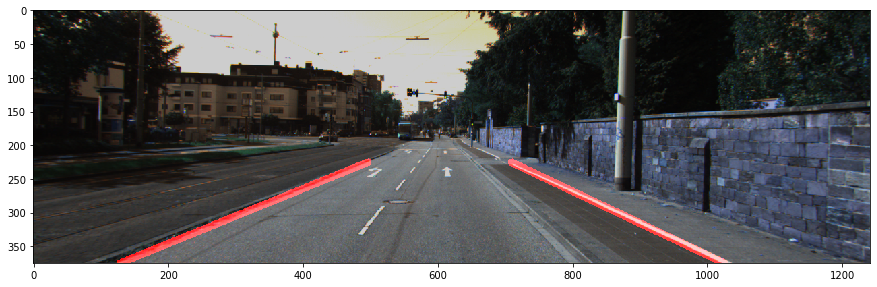

In [98]:
def make_coordinates(img, line_params):
    slope, intercept = line_params
    y1 = img.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1, y1, x2, y2])
def average_slope_intercept(img, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        params = np.polyfit((x1, x2), (y1, y2), 1)
        slope = params[0]
        intercept = params[1]
        if slope <0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_avg = np.average(left_fit, axis=0)
    right_fit_avg = np.average(right_fit, axis=0)
    left_line = make_coordinates(img, left_fit_avg)
    right_line = make_coordinates(img, right_fit_avg)
    return np.array([left_line, right_line])

avg_line = average_slope_intercept(img, lines)
line_img = display_lines(img, avg_line)
combine_line_img = cv2.addWeighted(img, 0.8, line_img, 1, 1)
plt.figure(figsize=(15,15))
plt.imshow(combine_line_img)

**Some results

*Success
![succeed](output/um_000028.png_out.png)
![succeed](output/um_000025.png_out.png)
![succeed](output/um_000026.png_out.png)
*Fail
![fail](output/um_000003.png_out.png)
![fail](output/um_000013.png_out.png)
![fail](output/um_000014.png_out.png)